# Feed Forward Neural Network Classifier

## Dependencies

In [1]:
import time
import numpy as np
import pandas as pd
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from create_training_set import create_data

## Import Data and Preprocess

__Import Data__

In [2]:
start = time.time()
df = create_data()
end = time.time()
print("Time elapsed: ", end-start)

Do you wish to save to csv? Y/N: N
Operation complete.  Quitting.
Time elapsed:  128.44493293762207


__Preprocess__

In [3]:
# Relabel Method from strings to a numerical representation (0 for 2d, 1 for 3d, and 2 for None)
df['METHOD'] = df['METHOD'].astype('category')
df['METHOD'] = df['METHOD'].cat.rename_categories({'2d simpson biplane': 0, '3d imaging': 1, 'None': 2})

In [4]:
# Cut the set down to just the cleaned Note Text and to the Label
df_copy = df # copy
df = df[['NOTE_CLEAN', 'METHOD']]
# Separate out the labels 
labels = np.array(df['METHOD'])
print("Shape of label vector: ", labels.shape)
print("Type: ", type(labels))

Shape of label vector:  (5056,)
Type:  <class 'numpy.ndarray'>


In [5]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(df['NOTE_CLEAN']).todense() # (documents, vocab)

print("Shape of document term matrix: ", vectors_tfidf.shape)
print("Type: ", type(vectors_tfidf))

Shape of document term matrix:  (5056, 3478)
Type:  <class 'numpy.matrix'>


__Preview Vocab__

In [6]:
vocab = np.array(vectorizer_tfidf.get_feature_names())

In [7]:
vocab[100:120]

array(['109', '10cm²', '10mm', '10mmhg', '10x', '11', '110', '111',
       '1110', '1114', '112', '112020', '1132', '114', '115', '1153',
       '1155', '116', '118', '119'], dtype='<U19')

__Create Target Array__

In [8]:
df['METHOD'].describe()
target = np.array(df['METHOD'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(vectors_tfidf, target)

## Re-Sampling

Over and under-sample the dataset to create a balanced dataset.

__Undersample majority classes__

In [10]:
# Define undersampling strategy
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={0: 1000, 2: 1000})
# Fit and apply the transform 
X_under, y_under = undersample.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='METHOD', ylabel='count'>

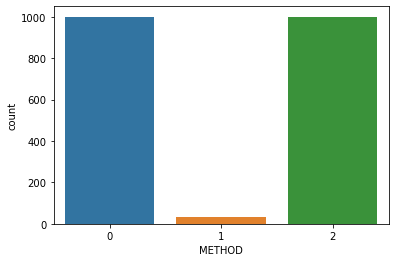

In [11]:
sns.countplot(x='METHOD', data = pd.DataFrame(y_under, columns=['METHOD']))

__Oversample minority classes__

In [12]:
# Define oversample strategy 
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority') # oversample minority class
# Fit and apply the transform
X_over, y_over = oversample.fit_resample(X_under, y_under)

__Results of re-sampling__

<AxesSubplot:xlabel='METHOD', ylabel='count'>

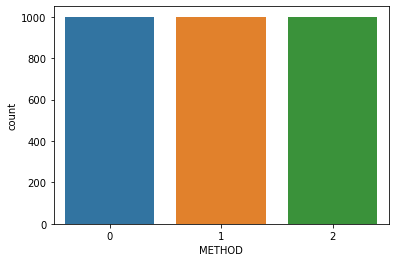

In [13]:
sns.countplot(x='METHOD', data = pd.DataFrame(y_over, columns=['METHOD']))

## Feed Forward Neural Network Model

__Build the model__

In [14]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(700, activation=tf.nn.relu, input_shape=(3478,)))
model.add(tf.keras.layers.Dense(700, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(140, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(140, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(28, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(28, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

Compile:

In [15]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
119/119 [==============================] - 4s 21ms/step - loss: 0.5914 - accuracy: 0.7370
Epoch 2/10
119/119 [==============================] - 3s 21ms/step - loss: 0.1064 - accuracy: 0.9649
Epoch 3/10
119/119 [==============================] - 3s 25ms/step - loss: 0.0492 - accuracy: 0.9850
Epoch 4/10
119/119 [==============================] - 3s 23ms/step - loss: 0.0468 - accuracy: 0.9843
Epoch 5/10
119/119 [==============================] - 2s 21ms/step - loss: 0.0190 - accuracy: 0.9929
Epoch 6/10
119/119 [==============================] - 3s 21ms/step - loss: 0.0118 - accuracy: 0.9961
Epoch 7/10
119/119 [==============================] - 3s 22ms/step - loss: 0.0152 - accuracy: 0.9942
Epoch 8/10
119/119 [==============================] - 3s 22ms/step - loss: 0.0130 - accuracy: 0.9962
Epoch 9/10
119/119 [==============================] - 3s 22ms/step - loss: 0.0088 - accuracy: 0.9980
Epoch 10/10
119/119 [==============================] - 3s 23ms/step - loss: 0.0059 - accura

Evaluate: 

In [16]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

40/40 [==============================] - 0s 7ms/step - loss: 0.3114 - accuracy: 0.9446
0.31138020753860474 0.9446202516555786


Save the model

In [19]:
model.save('medrec_classifier.model')

INFO:tensorflow:Assets written to: medrec_classifier.model/assets


Re-load the model

In [20]:
new_model = tf.keras.models.load_model('medrec_classifier.model')

Make predictions

In [21]:
predictions = new_model.predict([X_test])

In [42]:
print(y_test[:10])

[0 2 0 0 2 2 0 0 0 2]


In [30]:
print(np.argmax(predictions[0]))

0


In [43]:
print(np.argmax(predictions[5]))

2


In [44]:
print(np.argmax(predictions[9]))

2
